# Set up the environment and suppress warnings.


In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [11]:
import numpy as np
import pandas as pd
import os
import shutil
from pathlib import Path
import tensorflow as tf
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Set interactive shell settings
InteractiveShell.ast_node_interactivity = "all"

# Train-Test Data Preparation Function:


In [3]:
# Function to prepare train-test splits
def prepare_for_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test


# Model Architecture Function:

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    print(model.summary())
    return model


# Model Training Function:

In [5]:
def train_model(model, X_train, Y_train, EPOCHS=35):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=EPOCHS, callbacks=[reduce_lr, early_stop])
    return history

# Model Testing and Evaluation Function:

In [6]:
# Function to test the model
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred_one_hot = to_categorical(np.argmax(y_pred, axis=1), num_classes=8)
    clr = classification_report(Y_test, y_pred_one_hot, target_names=label_mapping.values())
    print(clr)
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[np.argmax(y_true[i])] + '|' + label_mapping[np.argmax(y_pred[i])])
        plt.axis("off")
    plt.show()

# Training Curve Plotting Function:



In [59]:

def plot_model_training_curve(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Image Loading and Resizing Function:



In [8]:
# Function to load and resize image
def load_and_resize_image(file_path):
    try:
        img = Image.open(file_path)
        img = img.resize((64, 64))
        img_array = np.asarray(img)
        return img_array
    except Exception as e:
        print(f"Error loading image at {file_path}: {e}")
        return None

# Data Loading and Initial Processing:



In [9]:
# Read CSV files
dfGT = pd.read_csv('/kaggle/input/skin-lesions/ISIC_2019_Training_GroundTruth.csv')
dfTM = pd.read_csv('/kaggle/input/skin-lesions/ISIC_2019_Test_Metadata.csv')
dfTrM = pd.read_csv('/kaggle/input/skin-lesions/ISIC_2019_Training_Metadata.csv')

# Create a directory for output files
output_folder = '/kaggle/working/training_metadata'
os.makedirs(output_folder, exist_ok=True)

# Function to get dx based on ground truth columns
def get_dx(row):
    for c in dfGT.columns:
        if row[c] == 1:
            return c

# Add a new 'dx' column to the training metadata DataFrame
dfTrM['dx'] = dfGT.apply(get_dx, axis=1)

# Save the updated training metadata DataFrame to a new CSV file
output_filepath = os.path.join(output_folder, 'ISIC_2019_Training_Metadata_with_dx.csv')
dfTrM.to_csv(output_filepath, index=False)
print(f"File saved to: {output_filepath}")

# Copy one of the input files to the output folder
shutil.copy('/kaggle/input/skin-lesions/ISIC_2019_Training_Metadata.csv', output_folder)
print(f"File copied to: {output_folder}")

File saved to: /kaggle/working/training_metadata/ISIC_2019_Training_Metadata_with_dx.csv


'/kaggle/working/training_metadata/ISIC_2019_Training_Metadata.csv'

File copied to: /kaggle/working/training_metadata


# Constants and Dictionaries Setup:



In [13]:
# Constants
base_skin_dir = Path('..', 'input')
training_input_dir = base_skin_dir / "skin-lesions/ISIC_2019_Training_Input"

# Imageid path dictionary
imageid_path_dict = {
    Path(x).stem: x
    for x in glob(str(training_input_dir / '*' / '*.jpg'))
}

# Lesion type dictionary using list comprehension
lesion_type_dict = {
    'NV': 'melanocytic nevi',
    'MEL': 'melanoma',
    'BCC': 'basal cell carcinoma',
    'AK': 'Actinic keratoses and intraepithelial carcinoma',
    'VASC': 'vascular lesions',
    'BKL': 'benign keratosis-like',
    'DF': 'dermatofibroma',
    'SCC': 'squamous cell carcinoma'
}

# Label mappings
label_mapping = {0: 'NV', 1: 'MEL', 2: 'BCC', 3: 'AK', 4: 'VASC', 5: 'BKL', 6: 'DF', 7: 'SCC'}

# Reverse label mapping
reverse_label_mapping = {value: key for key, value in label_mapping.items()}


# Load Processed Data and Image Path Mapping:



In [16]:
# Load CSV file
csv_path = '/kaggle/working/training_metadata/ISIC_2019_Training_Metadata_with_dx.csv'
data = pd.read_csv(csv_path)

# Map image paths and cell types
data['path'] = data['image'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get)

# Drop 'lesion_id' column
data.drop('lesion_id', axis=1, inplace=True)

# Handling null values
data['age_approx'].fillna(value=int(data['age_approx'].mean()), inplace=True)

# Convert dtype of 'age_approx' to int32
data['age_approx'] = data['age_approx'].astype('int32')

# Add 'image_pixel' column using apply and lambda
data['image_pixel'] = data['path'].apply(lambda x: load_and_resize_image(x))


# Sample Image Display:



<Figure size 1500x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'melanocytic nevi')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'melanocytic nevi')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'melanoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'melanoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'benign keratosis-like')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'benign keratosis-like')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'dermatofibroma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'squamous cell carcinoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'dermatofibroma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'basal cell carcinoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'basal cell carcinoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'vascular lesions')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'squamous cell carcinoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'vascular lesions')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Actinic keratoses and intraepithelial carcinoma')

(-0.5, 63.5, 63.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Actinic keratoses and intraepithelial carcinoma')

(-0.5, 63.5, 63.5, -0.5)

Text(0.5, 0.92, 'Sample Images for Each Skin Lesion Type')

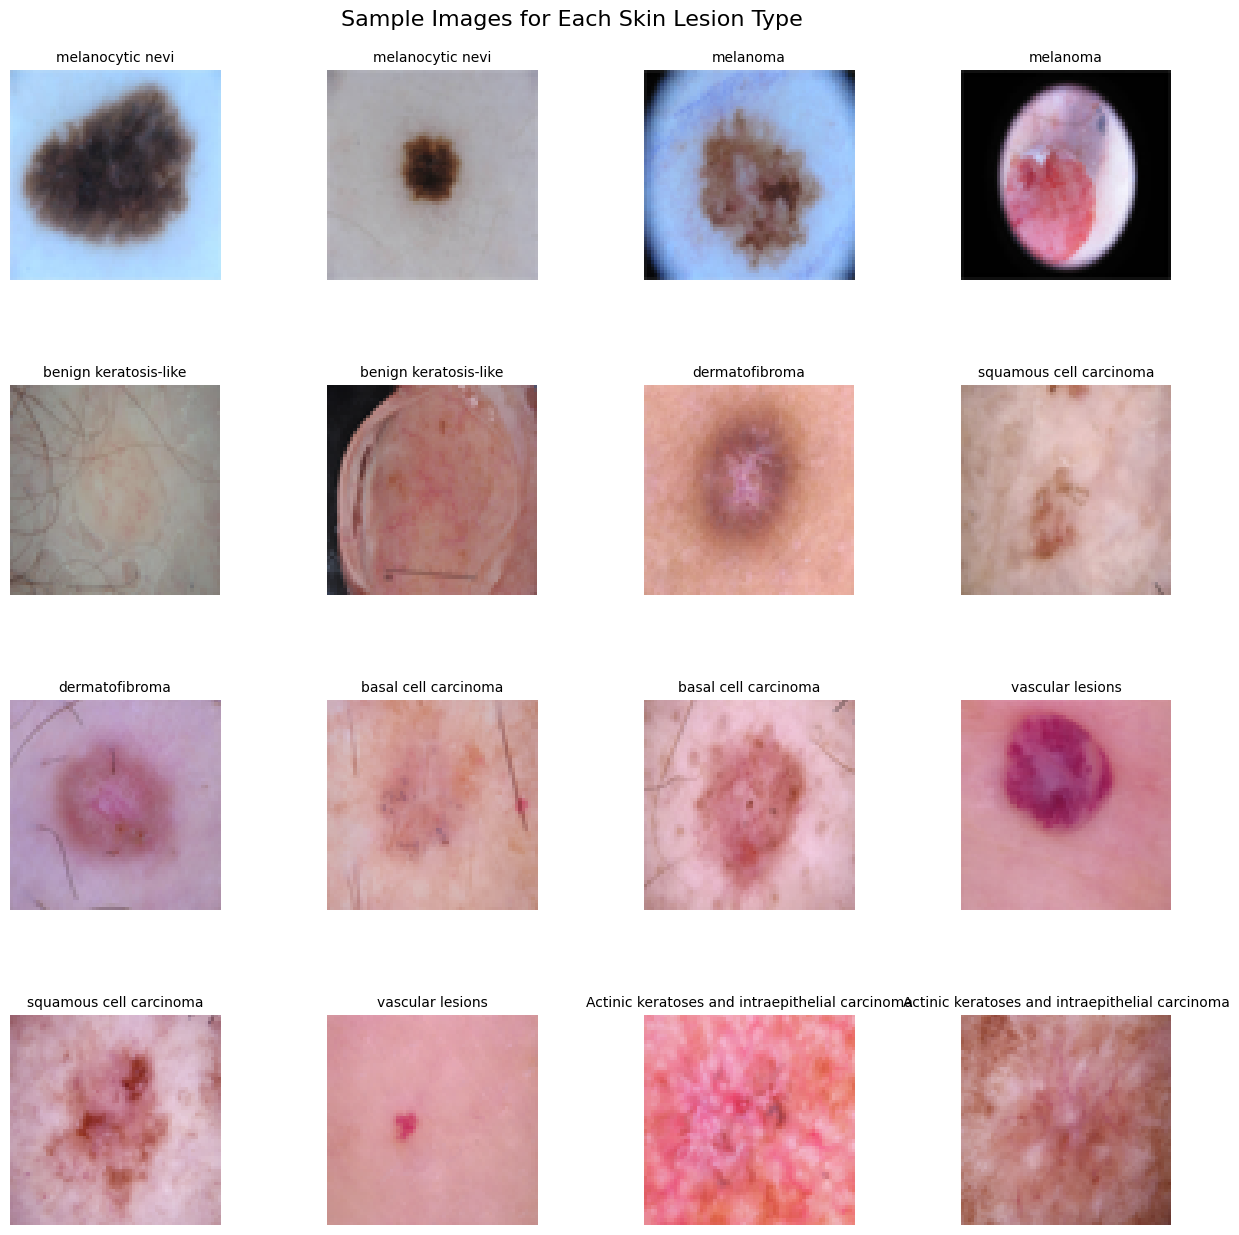

In [17]:
# Sample two images for each skin lesion type
sample_data = data.groupby('dx').head(2).reset_index(drop=True)

# Display sample images
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, row in sample_data.iterrows():
    plt.subplot(4, 4, i + 1)
    
    try:
        plt.imshow(np.squeeze(row['image_pixel']), cmap='gray')
        plt.title(row['cell_type'], fontsize=10)
        plt.axis("off")
    except IndexError as e:
        print(f"Error at index {i}: {e}")

plt.suptitle("Sample Images for Each Skin Lesion Type", fontsize=16, y=0.92)
plt.show()


# Label Mapping and Sorting:



In [18]:
data['label'] = data['dx'].map(reverse_label_mapping.get)
data = data.sort_values('label').reset_index(drop=True)

# Data Augmentation:



In [21]:
counter = 0
frames = [data]

for i in [4, 4, 11, 17, 45, 52, 53, 54]:
    counter += 1
    index = data[data['label'] == counter].index.values

    if len(index) > 0:
        df_index = data.iloc[int(min(index)):int(max(index) + 1)]
        df_index = pd.concat([df_index[['image_pixel', 'label']]] * i, ignore_index=True)
        frames.append(df_index)
    else:
        print(f"No rows found for counter value: {counter}")

resulting_dataframe = pd.concat(frames, ignore_index=True)

No rows found for counter value: 8


# Data Overview and Shape Comparison:



In [22]:
final_data = pd.concat(frames)
print(data.shape)
print(final_data.shape)

(25331, 9)
(234341, 9)


# Prepare Augmented Data for Model Training:



In [23]:
# AUGMENTED DATA
# Converting image pixel column into the required format
X_aug = np.stack(final_data['image_pixel'].to_numpy(), axis=0)
Y_aug = final_data.iloc[:, -1:].values

print(X_aug.shape)
print(Y_aug.shape)


(234341, 64, 64, 3)
(234341, 1)


# One-Hot Encode Labels:



In [24]:
# Convert integer labels to one-hot encoded labels
Y_aug = to_categorical(Y_aug, num_classes=8)

# Create Model Architecture:



In [25]:
model =create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

# Train-Test Data Split for Augmented Data:



In [26]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
print(X_train_aug.shape)
print(Y_train_aug.shape)

(187472, 64, 64, 3)
(187472, 8)


# Model Training:



In [27]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
2344/2344 [==============================] - 306s 130ms/step - loss: 1.0542 - accuracy: 0.6538 - val_loss: 0.7014 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 2/50
2344/2344 [==============================] - 300s 128ms/step - loss: 0.4974 - accuracy: 0.8330 - val_loss: 0.3685 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 3/50
2344/2344 [==============================] - 319s 136ms/step - loss: 0.3365 - accuracy: 0.8834 - val_loss: 0.2971 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 4/50
2344/2344 [==============================] - 301s 128ms/step - loss: 0.2668 - accuracy: 0.9069 - val_loss: 0.2886 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 5/50
2344/2344 [==============================] - 300s 128ms/step - loss: 0.2294 - accuracy: 0.9203 - val_loss: 0.1964 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 6/50
2344/2344 [==============================] - 299s 127ms/step - loss: 0.1905 - accuracy: 0.9342 - val_loss: 0.2301 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 7/50
2344/2344 [============

In [30]:
model.save('Skin_Cancer.sav')

In [45]:
# Save only the weights of the model
model.save_weights('/kaggle/working/skin_cancer_weights.h5')


In [46]:
from tensorflow.keras.models import load_model

# Load the model architecture (for TensorFlow Lite conversion)
loaded_model = create_model()

# Load the saved weights
loaded_model.load_weights('/kaggle/working/skin_cancer_weights.h5')

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/kaggle/working/skin_cancer_model.tflite', 'wb') as f:
    f.write(tflite_model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)         

928956

In [47]:
from IPython.display import FileLink

FileLink(r'skin_cancer_weights.h5')
FileLink(r'skin_cancer_model.tflite')


/kaggle/working/skin_cancer_weights.h5

/kaggle/working/skin_cancer_model.tflite

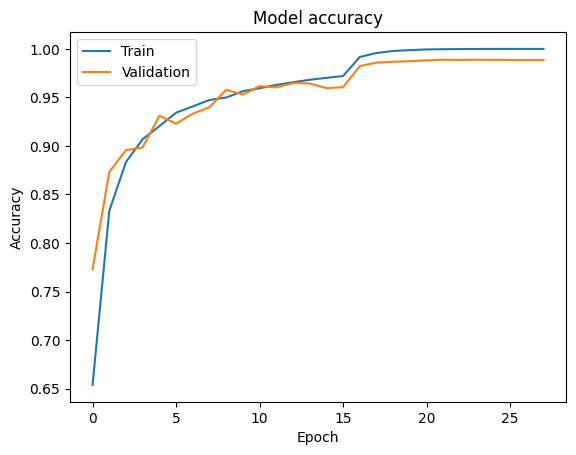

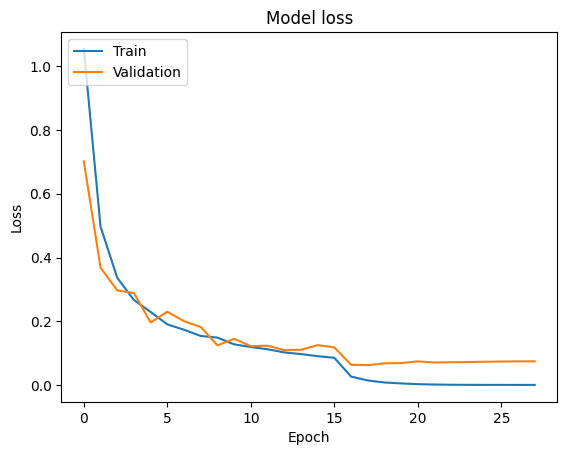

In [60]:
plot_model_training_curve(model2_history)

1465/1465 [==============================] - 30s 20ms/step


<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - NV')

Text(0.5, 624.2516339869283, 'Predicted')

Text(158.22222222222223, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - MEL')

Text(0.5, 624.2516339869283, 'Predicted')

Text(568.5163398692812, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - BCC')

Text(0.5, 624.2516339869283, 'Predicted')

Text(978.81045751634, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - AK')

Text(0.5, 352.4869281045751, 'Predicted')

Text(158.22222222222223, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - VASC')

Text(0.5, 352.4869281045751, 'Predicted')

Text(568.5163398692812, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - BKL')

Text(0.5, 352.4869281045751, 'Predicted')

Text(978.81045751634, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - DF')

Text(0.5, 80.7222222222222, 'Predicted')

Text(158.22222222222223, 0.5, 'True')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - SCC')

Text(0.5, 80.7222222222222, 'Predicted')

Text(568.5163398692812, 0.5, 'True')

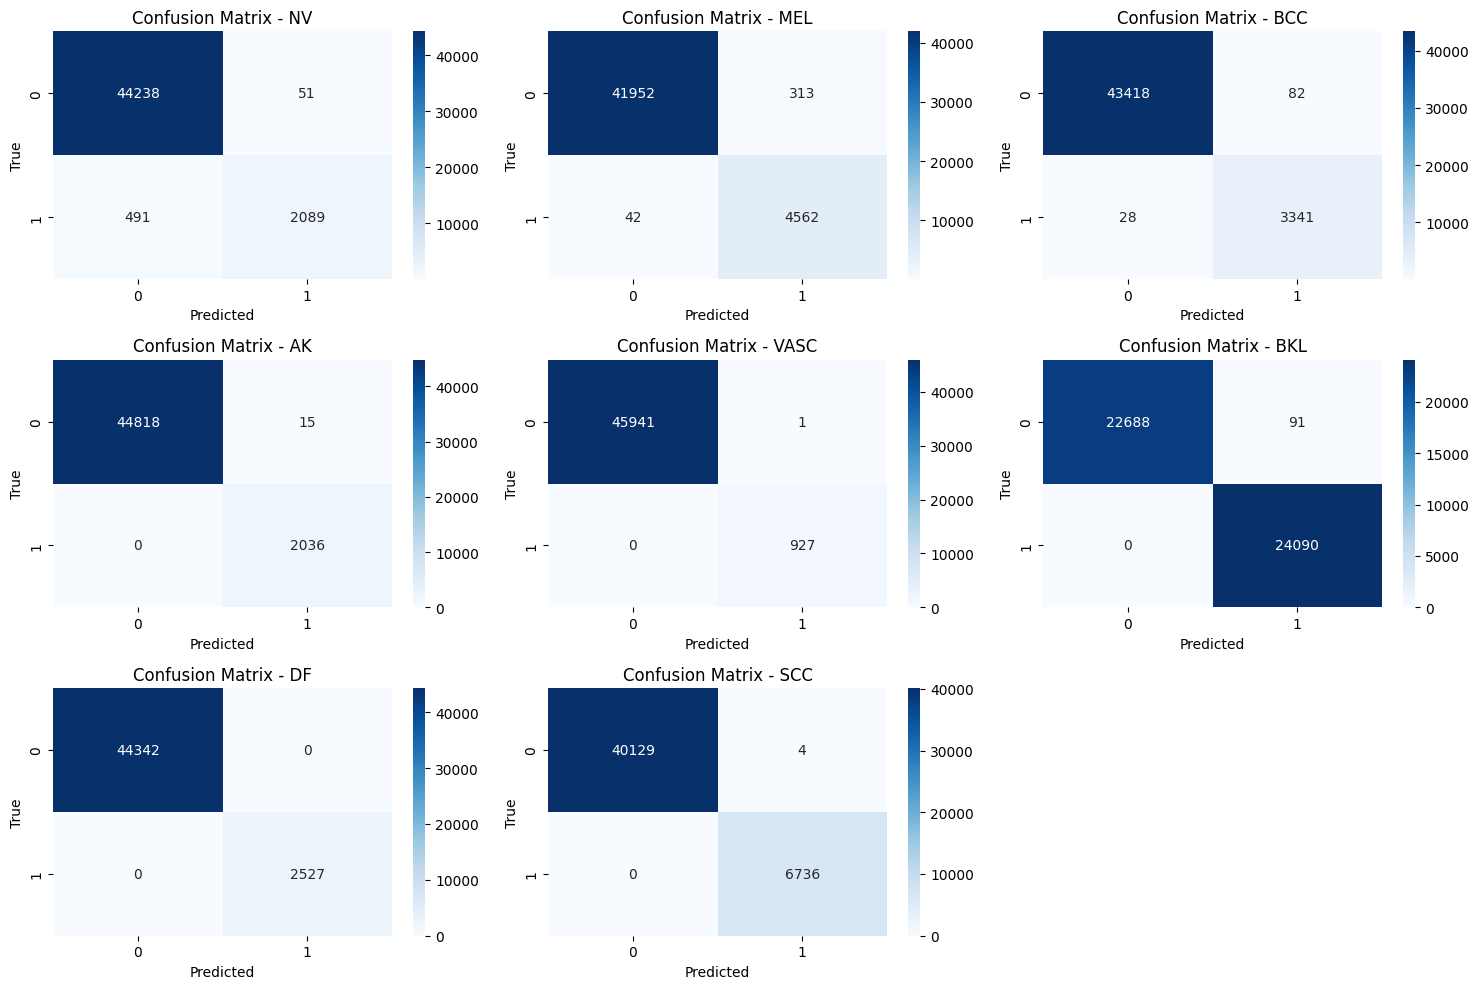

In [39]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your predictions are stored in a variable called 'predictions'
# and the true labels are stored in a variable called 'Y_test_aug'
predictions = model.predict(X_test_aug)  # Replace with your actual predictions

# Convert predictions and true labels to binary format
threshold = 0.5  # You may need to adjust this threshold based on your model
binary_predictions = (predictions > threshold).astype(int)
binary_true_labels = Y_test_aug

# Calculate the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(binary_true_labels, binary_predictions)

# Plot the confusion matrix for each class
classes = ["NV", "MEL", "BCC", "AK", "VASC", "BKL", "DF", "SCC"]

plt.figure(figsize=(15, 10))
for i, matrix in enumerate(confusion_matrices):
    plt.subplot(3, 3, i + 1)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f'Confusion Matrix - {classes[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()


Test Accuracy: 98.807%
1465/1465 [==============================] - 30s 20ms/step
              precision    recall  f1-score   support

          NV       0.98      0.81      0.89      2580
         MEL       0.94      0.99      0.96      4604
         BCC       0.98      0.99      0.98      3369
          AK       0.99      1.00      1.00      2036
        VASC       1.00      1.00      1.00       927
         BKL       1.00      1.00      1.00     24090
          DF       1.00      1.00      1.00      2527
         SCC       1.00      1.00      1.00      6736

   micro avg       0.99      0.99      0.99     46869
   macro avg       0.98      0.97      0.98     46869
weighted avg       0.99      0.99      0.99     46869
 samples avg       0.99      0.99      0.99     46869



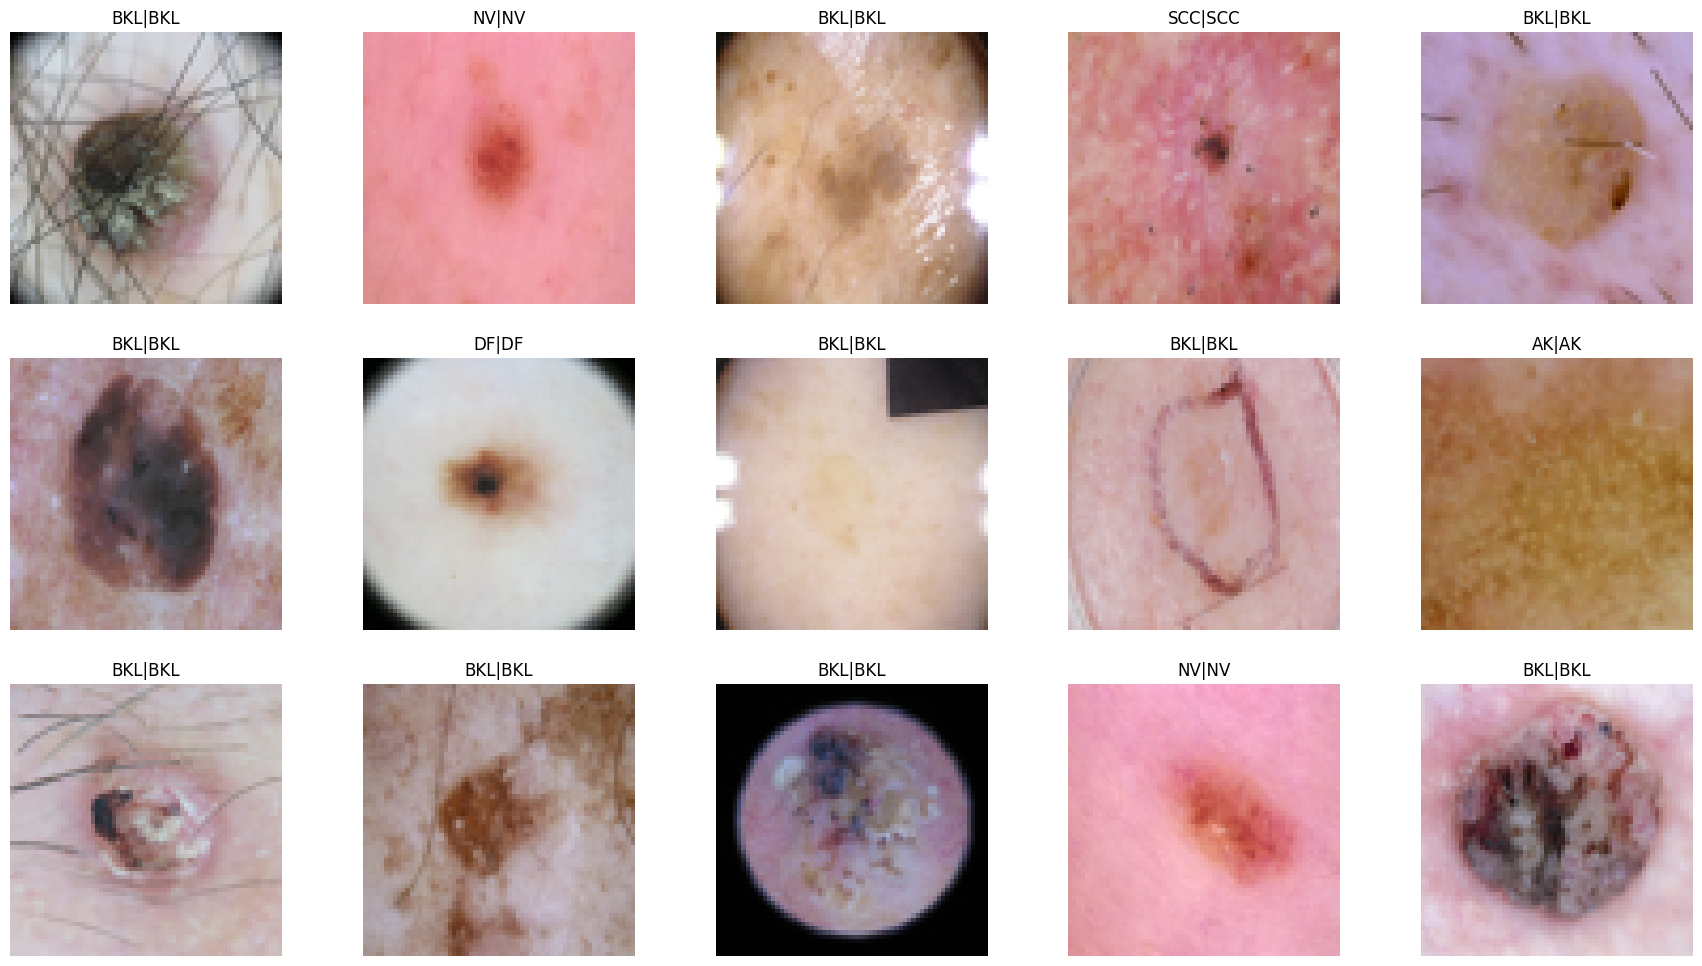

In [29]:
test_model(model, X_test_aug, Y_test_aug)
